# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain Data

Read csv file with Tempurature data into Pandas and drop non-NYC tempurature columns

In [2]:
df = pd.read_csv('Data/temperature.csv')
df = df[['datetime','New York']]
df.columns = ['Period', 'NYC Tempurature']
df.head()

,Period,NYC Tempurature
0,10/1/12 12:00,NaN
1,10/1/12 13:00,288.220000
2,10/1/12 14:00,288.247676
3,10/1/12 15:00,288.326940
4,10/1/12 16:00,288.406203


# Scrub Data

Use df.info() to determine what dataset scrubbing needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
Period             45253 non-null object
NYC Tempurature    44460 non-null float64
dtypes: float64(1), object(1)
memory usage: 707.2+ KB


Change Period column data type to datetime

In [4]:
df['Period'] = pd.to_datetime(df['Period'], dayfirst=True)
df.head()

,Period,NYC Tempurature
0,2012-01-10 12:00:00,NaN
1,2012-01-10 13:00:00,288.220000
2,2012-01-10 14:00:00,288.247676
3,2012-01-10 15:00:00,288.326940
4,2012-01-10 16:00:00,288.406203


View missing time series values

In [5]:
df[df['NYC Tempurature'].isna()]

,Period,NYC Tempurature
0,2012-01-10 12:00:00,NaN
44461,2017-10-28 01:00:00,NaN
44462,2017-10-28 02:00:00,NaN
44463,2017-10-28 03:00:00,NaN
44464,2017-10-28 04:00:00,NaN
...,...,...
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN


Remove rows with missing tempurature values at start and end of time series

In [6]:
df = df.loc[1:44460, :]
df

,Period,NYC Tempurature
1,2012-01-10 13:00:00,288.220000
2,2012-01-10 14:00:00,288.247676
3,2012-01-10 15:00:00,288.326940
4,2012-01-10 16:00:00,288.406203
5,2012-01-10 17:00:00,288.485467
...,...,...
44456,2017-10-27 20:00:00,289.980000
44457,2017-10-27 21:00:00,289.480000
44458,2017-10-27 22:00:00,287.920000
44459,2017-10-27 23:00:00,285.830000


Plot time series dataset to look for outliers

[Text(0, 0, '2012-01-10T13:00:00.000000000'),
 Text(0, 0, '2012-01-10T14:00:00.000000000'),
 Text(0, 0, '2012-01-10T15:00:00.000000000'),
 Text(0, 0, '2012-01-10T16:00:00.000000000'),
 Text(0, 0, '2012-01-10T17:00:00.000000000'),
 Text(0, 0, '2012-01-10T18:00:00.000000000'),
 Text(0, 0, '2012-01-10T19:00:00.000000000')]

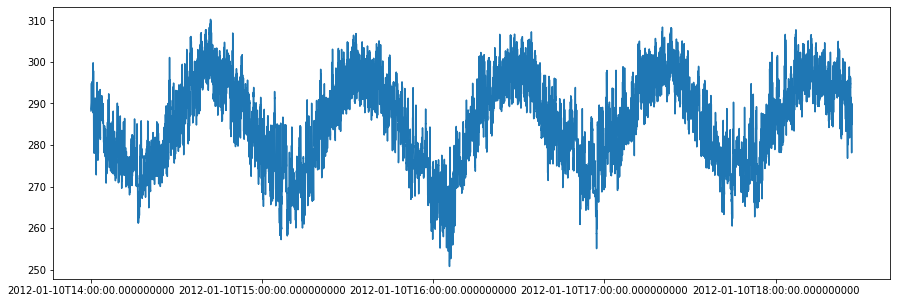

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['NYC Tempurature'].values)
ax.set_xticklabels(df['Period'].values)

Use df.info() to confirm dataset now scrubbed

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44460 entries, 1 to 44460
Data columns (total 2 columns):
Period             44460 non-null datetime64[ns]
NYC Tempurature    44460 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 694.8 KB
